In [258]:
from topagnps2cche1d.tools import find_extremities_binary
import numpy as np
import networkx as nx

In [84]:
def get_neighborhood(I, r, c):
    neighborhood = np.array(
        [
            [
                I[r - 1, c - 1] if (r - 1 >= 0) and (c - 1 >= 0) else 0,
                I[r - 1, c] if r - 1 >= 0 else 0,
                I[r - 1, c + 1] if (r - 1 >= 0) and (c + 1 <= I.shape[1]) else 0,
            ],
            [
                I[r, c - 1] if (c - 1 > 0) else 0,
                I[r, c],
                I[r, c + 1] if (c + 1 <= I.shape[1] - 1) else 0,
            ],
            [
                I[r + 1, c - 1] if (r + 1 <= I.shape[0] - 1) and (c - 1 >= 0) else 0,
                I[r + 1, c] if r + 1 <= I.shape[0] - 1 else 0,
                I[r + 1, c + 1]
                if (r + 1 <= I.shape[0] - 1) and (c + 1 <= I.shape[1])
                else 0,
            ],
        ]
    )
    return neighborhood

In [298]:
def path_crawler(rowcols, maxiter=100):
    deltas = {
        (-1,  0): 'North',
        ( 0 ,-1): 'West',
        ( 1 , 0): 'South',
        ( 0 , 1): 'East',
        (-1 ,-1): 'NorthWest',
        ( 1 ,-1): 'SouthWest',
        ( 1 , 1): 'SouthEast',
        (-1 , 1): 'NorthEast'
    }

    G = nx.Graph()

    rowcols_to_visit = rowcols.copy()

    rowcol = rowcols_to_visit.pop(0)

    if not rowcols_to_visit:
        # only one node
        G.add_node(rowcol)

    iter = 0
    while rowcols_to_visit:
        iter += 1
        if iter == maxiter:
            raise Exception('Maximum number of iterations reached! Probably invalid path')  

        for delta in deltas:
            rowcolnext = (rowcol[0]+delta[0],rowcol[1]+delta[1])

            if rowcolnext in rowcols_to_visit:
                G.add_edge(rowcol, rowcolnext)
                # jump there
                rowcol = rowcolnext
                rowcols_to_visit.remove(rowcolnext)
                break

    return G



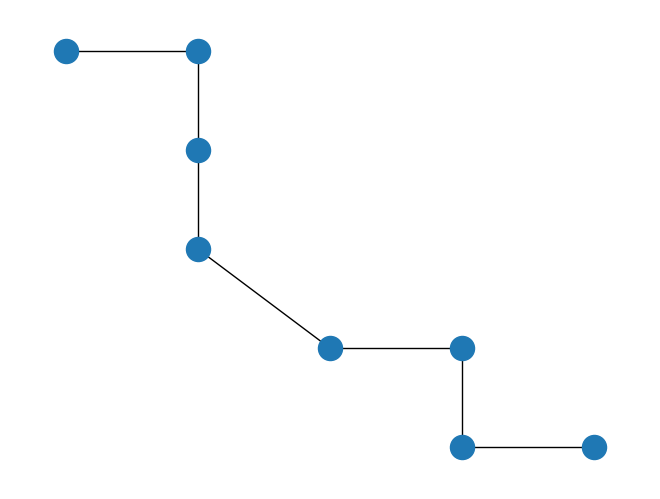

In [299]:
I = np.array([[1, 1, 0, 0, 0],
              [0, 1, 0, 0, 0], 
              [0, 1, 0, 0, 0], 
              [0, 0, 1, 1, 0],
              [0, 0, 0, 1, 1]])

(rows, cols) = np.nonzero(I)

rowcols = [(r,c) for r, c in zip(rows,cols)]

G = path_crawler(rowcols)

pos = {node: [node[1], -node[0]] for node in G.nodes()}

nx.draw(G,pos=pos)

In [300]:
def find_extremities_binary(img, output_index_starts_one=False):

    (rows, cols) = np.nonzero(img)

    rowcols = [(row, col) for row, col in zip(rows,cols)]

    G = path_crawler(rowcols)

    extremities = [rowcol for rowcol in G.nodes() if nx.degree(G, rowcol) <=1]

    if output_index_starts_one:
        extremities = [(r + 1, c + 1) for r, c in extremities]
        
    return extremities

In [301]:
# I = np.array([[1, 1, 0, 0, 0],
#               [0, 1, 0, 0, 0], 
#               [0, 1, 0, 0, 0], 
#               [0, 1, 1, 0, 0],
#               [0, 0, 0, 1, 0]])

I = np.array([[1, 1, 0, 0, 0],
              [0, 1, 0, 0, 0], 
              [0, 1, 0, 0, 0], 
              [0, 0, 1, 1, 0],
              [0, 0, 0, 1, 1]])

# I = np.array([[0, 0, 0, 0, 0],
#               [1, 1, 0, 1, 1], 
#               [0, 1, 0, 1, 0], 
#               [0, 0, 1, 0, 0],
#               [0, 0, 0, 0, 0]])


extremities = find_extremities_binary(I)
print(extremities)

[(0, 0), (4, 4)]
